# Plots for $\min \|S - \mathrm{I}_d\|_\gamma$

In [1]:
import numpy as np
import pickle, time, copy
import glob
import itertools as it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os, re
colors = list(mcolors.TABLEAU_COLORS)
import os.path
plt.rcParams.update({'font.size': 15})

## Evolution of the spectrum in the $(\alpha, \gamma)$ plane

In [2]:
#We load all available data

folder_path = "../Data/replica/"
gamma01s = []#

# Define a regular expression to match filenames that contain "gamma0_{}_gamma1_{}.pkl"
filename_pattern = r"Min_Sgamma_minus_Id_gamma0_(.*)_gamma1_(.*).pkl$"

# Loop over all files in the directory and load the data
alphas_tmp, gammas_tmp, qs_tmp, hs_tmp, lmaxs_tmp = [], [], [], [], []

for filename in os.listdir(folder_path):
    # Match filenames that follow the pattern
    match = re.match(filename_pattern, filename)
    if match:
        gamma0 = float(match.group(1))
        gamma1 = float(match.group(2))
        gamma01s.append([gamma0, gamma1])
        filename = f"{folder_path}Min_Sgamma_minus_Id_gamma0_{gamma0}_gamma1_{gamma1}.pkl"
        infile = open(filename,'rb')
        results = pickle.load(infile)
        infile.close()
        
        alphas_tmp.append(results['alphas']) #alphas must be sorted
        gammas_tmp.append(results['gammas'])
        qs_tmp.append(results['qs'])
        hs_tmp.append(results['hs'])
        lmaxs_tmp.append(results['lmaxs'])
                
#Now we concatenate all the available data
gammas, alphas, qs, hs, lmaxs = [], [], [], [] , []
for (i_x, x) in enumerate(gammas_tmp):
    for (i_g, gamma) in enumerate(gammas_tmp[i_x]):
        gammas.append(gamma) 
        alphas.append(alphas_tmp[i_x])
        qs.append(qs_tmp[i_x][i_g])
        hs.append(hs_tmp[i_x][i_g])
        lmaxs.append(lmaxs_tmp[i_x][i_g])

#Now we sort, according to gammas
gammas = np.array(gammas)
idx   = np.argsort(gammas)
gammas = gammas[idx]
alphas = [alphas[i] for i in idx]
qs = [qs[i] for i in idx]
hs = [hs[i] for i in idx]
lmaxs = [lmaxs[i] for i in idx]

In [3]:
def sc(x):
    #Standard semicircular density
    if np.abs(x) >= 2:
        return 0.
    else:
        return np.sqrt(4. - x**2) / (2.*np.pi)

#Only for x > 0, for x < 0 we get it via symmetry
def nu(x, gamma_, h, q):
    if x > 0:
        arg = 2*gamma_*x**(gamma_-1)/np.sqrt(q) + h*np.sqrt(q)*x
        return (2.*gamma_*(gamma_-1)*x**(gamma_-2) / np.sqrt(q) + h*np.sqrt(q))*sc(arg)
    else:
        return nu(-x, gamma_, h, q)

The spectrum for different $\alpha$, for fixed $\gamma$. We draw in inset the evolution of $\lambda_{\max}(\alpha)$

In [4]:
def plot_fix_gamma(i_g):
    gammav = gammas[i_g]
    width = 8
    height = width / ((np.sqrt(5.)+1)/2.) #Golden ratio
    fig, ax = plt.subplots(1, 1,figsize = (width,height))
    
    alphas_approx = [0.1, 0.15, 0.20, 0.25]
    for alpha_ in alphas_approx:
        i_a = np.argmin(np.abs(alphas[i_g] - alpha_))
        alphav = alphas[i_g][i_a] 
        xs = np.linspace(1e-8, 5*lmaxs[i_g][i_a], num = 4000)
        xs = np.concatenate((-xs, xs))
        xs = np.sort(xs)
        xs = xs + 1 #We shift it back to be centered in 1
        values = np.array([nu(x - 1, gammav, hs[i_g][i_a], qs[i_g][i_a]) for x in xs])
        ax.plot(xs, values, label = r'$\alpha = {0}$'.format(round(alphav,2)), linewidth = 2.5)


    ax.set_title(r'$\gamma = {0}$'.format(round(gammav,2)), pad = 10)
    ax.plot([0,0],[-10,10], '--', linewidth=1.5, zorder=0, color='black')
    ax.plot([-10,10],[0,0], '--', linewidth=1., zorder=0, color='black')
    ax.set_ylabel(r'$\nu(x)$')
    ax.set_xlabel(r'$x$')
    ax.legend(fancybox=True,loc = 'upper left', ncol = 2)
    ax.set_ylim(-0.1,2.25)
    ax.set_xlim(-0.6,3.5)
    
    axins = ax.inset_axes([0.65, 0.65, 0.3, 0.3])
    axins.plot(alphas[i_g], 1.-lmaxs[i_g], linewidth=2, color = colors[5], label = r'$\lambda_{\min}$')
    axins.plot([-10,10],[0,0], '--', linewidth=1., zorder=0, color='black')
    axins.set_xlim(0.09,0.26)
    axins.set_yticks([0])
    axins.set_xticks([0.1,0.15, 0.2, 0.25])
    axins.set_xlabel(r'$\alpha$', labelpad = 0)
    axins.legend(fancybox=True,loc = 'best', fontsize = 10)
    axins.tick_params(axis='x', labelsize=10)
    axins.tick_params(axis='y', labelsize=10)

    plt.savefig('../Figures/nu_shift_id_fixed_gamma.pdf', bbox_inches='tight')

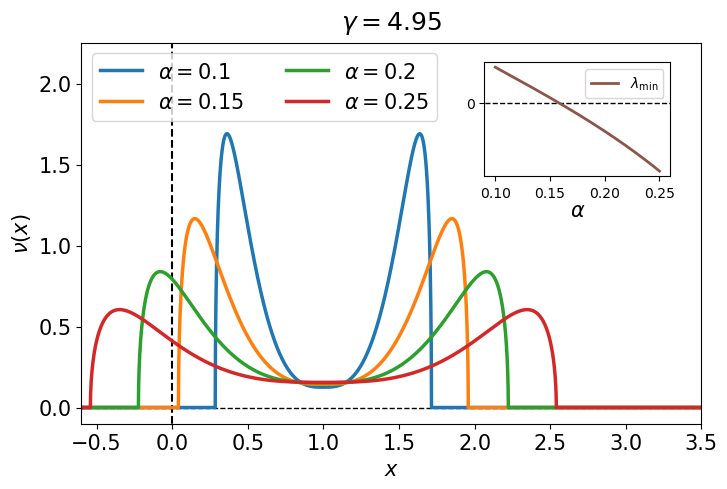

In [5]:
gamma_ = 5
i_g = np.argmin(np.abs(gammas - gamma_))
plot_fix_gamma(i_g)

The spectrum for different $\gamma$, for fixed $\alpha$. We draw in inset the evolution of $\lambda_{\max}(\gamma)$

In [6]:
def plot_fix_alpha(alphav):
    width = 8
    height = width / ((np.sqrt(5.)+1)/2.) #Golden ratio
    fig, ax = plt.subplots(1, 1,figsize = (width,height))
    
    gammas_approx = [1.1, 1.5, 2.0, 5.0, 10.0]
    for gamma_ in gammas_approx:
        i_g = np.argmin(np.abs(gammas - gamma_))
        gammav = gammas[i_g]
        i_a = np.argmin(np.abs(alphas[i_g] - alphav))
        xs = np.linspace(1e-8, 5*lmaxs[i_g][i_a], num = 4000)
        xs = np.concatenate((-xs, xs))
        xs = np.sort(xs)
        xs = xs + 1 #We shift it back to be centered in 1
        values = np.array([nu(x - 1, gammav, hs[i_g][i_a], qs[i_g][i_a]) for x in xs])
        ax.plot(xs, values, label = r'$\gamma = {0}$'.format(round(gammav,1)), linewidth = 2.5)


    ax.set_title(r'$\alpha = {0}$'.format(round(alphav,2)), pad = 10)
    ax.plot([0,0],[-10,10], '--', linewidth=1.5, zorder=0, color='black')
    ax.plot([-10,10],[0,0], '--', linewidth=1., zorder=0, color='black')
    ax.set_ylabel(r'$\nu(x)$')
    ax.set_xlabel(r'$x$')
    ax.legend(fancybox=True,loc = 'upper left', ncol = 3, fontsize = 10)
    ax.set_ylim(-0.1,2.25)
    ax.set_xlim(-0.6,3.5)
    
    
    axins = ax.inset_axes([0.68, 0.65, 0.3, 0.3])
    gammas_v = [] 
    lmaxs_v = []
    for (i_g, gamma_) in enumerate(gammas):
        i_a = np.argmin(np.abs(alphas[i_g] - alphav))
        gammas_v.append(gammas[i_g])
        lmaxs_v.append(lmaxs[i_g][i_a])
    gammas_v, lmaxs_v = np.array(gammas_v), np.array(lmaxs_v)
    
    axins.plot(gammas_v, 1.-lmaxs_v, linewidth=2, color = colors[5], label = r'$\lambda_{\min}$')
    axins.plot([-10,100],[0,0], '--', linewidth=1., zorder=0, color='black')
    #axins.set_xlim(0.09,0.26)
    axins.set_yticks([0])
    #axins.set_xticks([0.1,0.15, 0.2, 0.25])
    axins.set_xlabel(r'$\gamma$', labelpad = 0)
    axins.legend(fancybox=True,loc = 'best', fontsize = 12)
    axins.tick_params(axis='x', labelsize=10)
    axins.tick_params(axis='y', labelsize=10)
    axins.set_xlim(1,20)
    axins.set_ylim(-0.5,0.1)

    plt.savefig('../Figures/nu_shift_id_fixed_alpha.pdf', bbox_inches='tight')

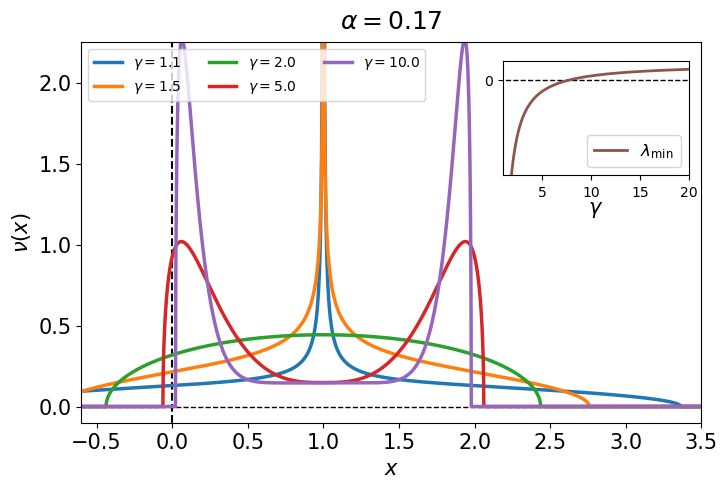

In [7]:
plot_fix_alpha(0.17)

## Numerical solution to the $\gamma = \infty$ equations

In [8]:
# A solver for the minimal nuclear norm solution
from scipy import optimize

#Fw(t) = \int_t^2 \rho_sci(u) du
def Fw(t):
    return -(t*np.sqrt(4.-t**2) - 8*np.arctan(np.sqrt(4.-t**2)/(t+2)))/(4*np.pi)

#F1(t) = \int_t^2 (u-t) \rho_sci(u) du
def F1(t):
    return ((8+t**2)*np.sqrt(4.-t**2) - 24*t*np.arctan(np.sqrt(4.-t**2)/(t+2)))/(12*np.pi)
    
#F2(t) = \int_0^t u^2 \rho_sci(u) du
def F2(t):
    return (np.pi+(t**2-2)*np.sqrt(4.-t**2)*t/4. - 4*np.arctan(np.sqrt(4.-t**2)/(t+2)))/(2*np.pi)

In [9]:
sol_t_infty = optimize.root_scalar(lambda t: t - 2*(1 - (t/2)*(1-t/2)/F1(t)), x0 = 0.5)
t_infty = sol_t_infty.root
w_infty = Fw(t_infty)
def alphac_infty(t):
    return (t**2/2.)*(1.+2*Fw(t)+(2./t**2)*F2(t))

In [10]:
print(t_infty, w_infty, alphac_infty(t_infty))

0.45759265102977664 0.3556247017793626 0.18916533353515422


In [11]:
def nu_gammainfty(x):
    if x > 0:
        return (x<1)*t_infty*sc(t_infty*x)
    else:
        return nu_gammainfty(-x)

## Plots of $\alpha_c(\gamma)$ and of the spectrum at $\alpha_c(\gamma)$

Now we plot how the spectrum at $\alpha = \alpha_c(\gamma)$ evolves as a function of $\gamma \in (1, \infty)$

In [12]:
#We load all available data

folder_path = "../Data/replica/"
gamma01s = []#

# Define a regular expression to match filenames that contain "gamma0_{}_gamma1_{}.pkl"
filename_pattern = r"Min_Sgamma_minus_Id_alphac_gamma0_(.*)_gamma1_(.*).pkl$"

# Loop over all files in the directory and load the data
alphacs_tmp, gammas_tmp, hcs_tmp, qcs_tmp = [], [], [], []

for filename in os.listdir(folder_path):
    # Match filenames that follow the pattern
    match = re.match(filename_pattern, filename)
    if match:
        gamma0 = float(match.group(1))
        gamma1 = float(match.group(2))
        gamma01s.append([gamma0, gamma1])
        filename = f"{folder_path}Min_Sgamma_minus_Id_alphac_gamma0_{gamma0}_gamma1_{gamma1}.pkl"
        infile = open(filename,'rb')
        results = pickle.load(infile)
        infile.close()
        
        alphacs_tmp.append(results['alphacs']) #alphas must be sorted
        gammas_tmp.append(results['gammas'])
        hcs_tmp.append(results['hcs'])
        qcs_tmp.append(results['qcs'])
        
#Now we concatenate all the available data
gammas = np.concatenate([x for x in gammas_tmp])
alphacs = np.concatenate([x for x in alphacs_tmp])
hcs = np.concatenate([x for x in hcs_tmp])
qcs = np.concatenate([x for x in qcs_tmp])

#Now we sort, and according to gammas
idx   = np.argsort(gammas)
gammas = np.array(gammas)[idx]
alphacs = np.array(alphacs)[idx]
hcs = np.array(hcs)[idx]
qcs = np.array(qcs)[idx]

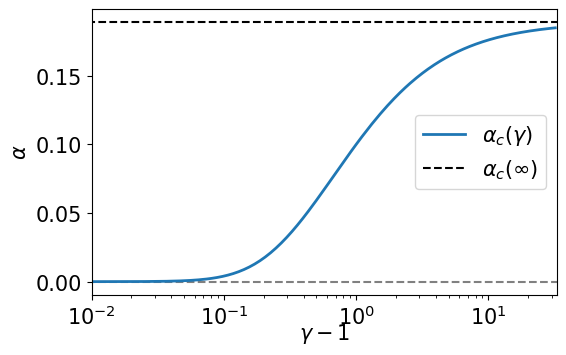

In [15]:
width = 6
height = width / ((np.sqrt(5.)+1)/2.) #Golden ratio
fig, ax = plt.subplots(1, 1,figsize = (width,height))
ax.plot(gammas-1, alphacs, linewidth = 2, color = colors[0], label = r'$\alpha_c(\gamma)$')
ax.plot([0.,200],[alphac_infty(t_infty),alphac_infty(t_infty)], '--', linewidth=1.5, zorder=0, color='black', label = r'$\alpha_c(\infty)$')
ax.plot([0.,200],[0,0], '--', linewidth=1.5, zorder=0, color='grey')
ax.set_xlim(0.01, 32.8)
ax.set_ylabel(r'$\alpha$')
ax.set_xlabel(r'$\gamma-1$', labelpad = -5)
ax.set_xscale('log')
ax.legend(fancybox=True,loc = 'best')
plt.savefig('../Figures/alphac_shift_id_gamma.pdf', bbox_inches='tight')

In [16]:
def sc(x):
    #Standard semicircular density
    if np.abs(x) >= 2:
        return 0.
    else:
        return np.sqrt(4. - x**2) / (2.*np.pi)

#Only for x > 0, for x < 0 we get it via symmetry
def nu(x, gamma_, h, q):
    if x > 0:
        arg = 2*gamma_*x**(gamma_-1)/np.sqrt(q) + h*np.sqrt(q)*x
        return (2.*gamma_*(gamma_-1)*x**(gamma_-2) / np.sqrt(q) + h*np.sqrt(q))*sc(arg)
    else:
        return nu(-x, gamma_, h, q)

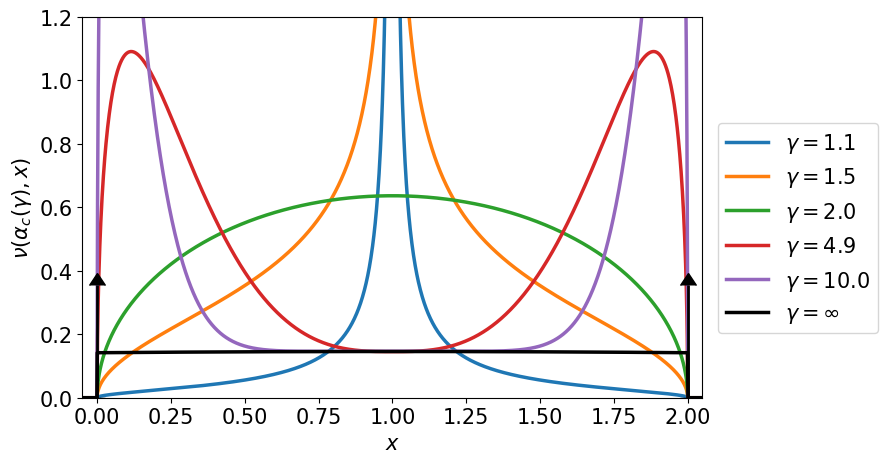

In [18]:
gammas_plot = np.array([1.1, 1.5, 2, 4.9, 10]) #The gammas to plot
width = 8
height = width / ((np.sqrt(5.)+1)/2.) #Golden ratio
fig, ax = plt.subplots(1, 1,figsize = (width,height))
xs = np.linspace(1e-8, 1.1, num = 1000)
xs = np.concatenate((-xs, xs))
xs = np.sort(xs)
xs = xs + 1 #We shift it back to be centered in 1

for (_, gamma) in enumerate(gammas_plot):
    #Find the value of gamma that is the closest in the list I have
    i_g = np.argmin(np.abs(gamma - gammas))
    values = np.array([nu(x - 1, gammas[i_g], hcs[i_g], qcs[i_g]) for x in xs])
    ax.plot(xs, values, label = r'$\gamma = {0}$'.format(round(gammas[i_g],1)), linewidth = 2.5)
    
values = np.array([nu_gammainfty(x - 1) for x in xs])
c_infty = 'black'
ax.plot(xs, values, label = r'$\gamma = \infty$', linewidth = 2.5, color = c_infty)
ax.errorbar(2,0.,yerr= w_infty, color=c_infty,uplims=False,lolims=True, elinewidth=2, capsize = 6)
ax.errorbar(0,0.,yerr= w_infty, color=c_infty,uplims=False,lolims=True, elinewidth=2, capsize = 6)
    
ax.legend(fancybox=True,loc = 'upper right', bbox_to_anchor = (1.3, 0.75), ncol = 1)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\nu(\alpha_c(\gamma), x)$')
ax.set_ylim(0,1.2)
ax.set_xlim(-0.05,2.05)
plt.savefig('../Figures/nu_shift_id_alphac_gamma.pdf', bbox_inches='tight')

## Comparison with numerical simulations for $\gamma = \infty$

We plot a comparison with the numerics, for $\alpha \simeq \alpha_c(\gamma = \infty) \simeq 0.1892$ 

In [21]:
alphac = 0.1892

#Loading numerical simulations
HISTOGRAM_KWARGS = {
    'facecolor': 'darkgray',
    'edgecolor': 'black',
    'linewidth': 1}

all_evals = {}
alpha_str = str(alphac).replace('.', '_')
pattern = f"../Data/finite_size/evals__dist_op__d100__a{alpha_str}__t*.csv"
evalss = []
for filename in glob.glob(pattern):
    evals = np.loadtxt(filename)
    evalss.append(evals)
all_evals = np.hstack(evalss)
print(len(evalss))

50


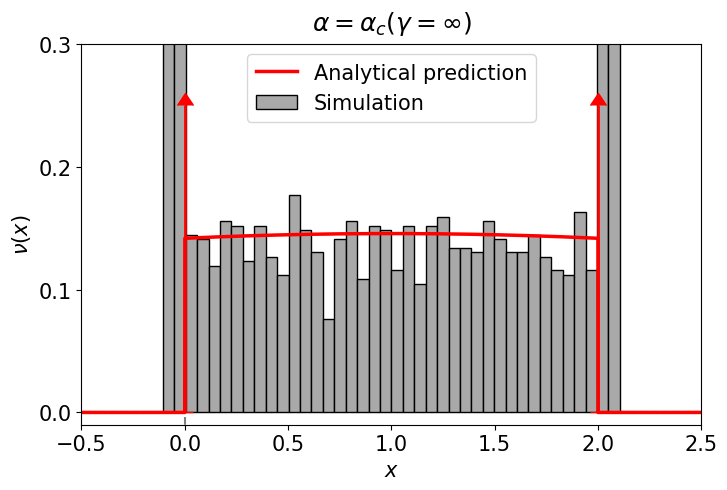

In [22]:
def sc(x):
    #Standard semicircular density
    if np.abs(x) >= 2:
        return 0.
    else:
        return np.sqrt(4. - x**2) / (2.*np.pi)

c_infty = 'red'
xs = np.linspace(1e-8, 3, num = 10000)
xs = np.concatenate((-xs, xs))
xs = np.sort(xs)
xs = xs + 1 #We shift it back to be centered in 1
values = np.array([nu_gammainfty(x - 1) for x in xs])

width = 8
height = width / ((np.sqrt(5.)+1)/2.) #Golden ratio
fig, ax = plt.subplots(1, 1,figsize = (width,height))

ax.plot(xs, values, label = r'Analytical prediction', linewidth = 2.5, color = c_infty)
ax.errorbar(2,0.,yerr= 0.25, color=c_infty,uplims=False,lolims=True, elinewidth=2, capsize = 6)
ax.errorbar(0,0.,yerr= 0.25, color=c_infty,uplims=False,lolims=True, elinewidth=2, capsize = 6)
    
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\nu(x)$')
ax.set_ylim(-0.01,0.3)
ax.set_xlim(-0.5,2.5)
ax.set_yticks([0,0.1,0.2,0.3])
ax.plot([-10,50],[0., 0.], '--', linewidth=1.5, color='grey', zorder = 0)
ax.plot([0,0],[-10., 10.], '--', linewidth=1.5, color='grey', zorder = 0)
ax.hist(all_evals, bins=40, density=True, **HISTOGRAM_KWARGS, zorder = 0, label = r'Simulation')
ax.legend(fancybox=True,loc = 'upper center', ncol = 1)
ax.set_title(r'$\alpha = \alpha_c(\gamma = \infty)$', pad = 10)
plt.savefig('../Figures/nu_shift_id_alphac_gamma_infty.pdf', bbox_inches='tight')